# Production-Ready Reinforcement Learning

Let's time to bridge the gap between theoretical knowledge and real-world application. This notebook
introduces the essential techniques and tools for making RL agents production-ready.

### What We'll Cover:

1.  **Code Structure & Refactoring**: How to structure code to be modular and reusable.
2.  **Metrics & Monitoring**: Using Tensorboard to track losses, rewards, and gradients.
3.  **Checkpointing**: Saving and loading models to resume training or for inference.
4.  **Debugging & Troubleshooting**: Common techniques for when your RL agent isn't learning.
5.  **The Importance of Multiple Seeds**: Ensuring your results are robust and reproducible.
6.  **Scaling with Parallelization (Ray)**: Speeding up training with parallel environments.
7.  **Automated Hyperparameter Tuning (Optuna)**: Finding the best hyperparameters automatically.
8.  **Other Production Techniques**: A look at MLOps, CI/CD, and Safe RL.

Let's dive in!


### Imports and Setup

First, let's import the necessary libraries. We'll be using PyTorch, Gymnasium, and several new
libraries for our production techniques.


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import os
import ray
import optuna
import copy

from util.gymnastics import gym_simulation, init_random

In [ ]:
RUNS_DIR = "runs"
CHECKPOINTS_DIR = "checkpoints"

os.makedirs(RUNS_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

init_random()

### A Note on Environment Choice: CartPole

`CartPole` provides a **dense reward** (+1 for every timestep the pole is balanced), which allows
our agent to learn quickly. This rapid feedback loop makes it much easier to see the effects of our
tooling and techniques without waiting a long time for the agent to solve a complex exploration
problem.


In [3]:
ENV_NAME = "CartPole-v1"
TEMP_ENV = gym.make(ENV_NAME)
STATE_DIM = TEMP_ENV.observation_space.shape[0]
ACTION_DIM = TEMP_ENV.action_space.n
TEMP_ENV.close()

/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


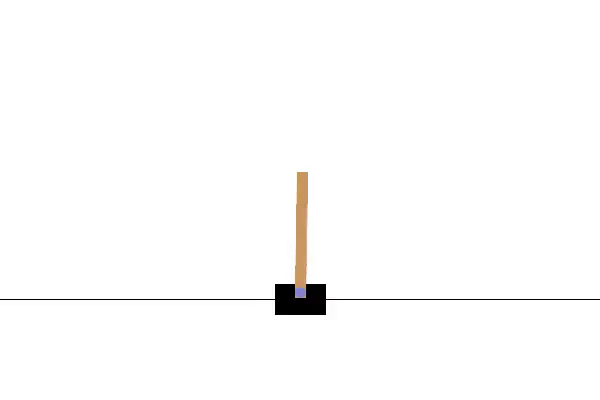

In [4]:
gym_simulation(ENV_NAME)

---


### Part 1: Modular Code Structure - An A2C Trainer

A key principle of production-ready code is **modularity**. Instead of rewriting the training loop
in every section, we will encapsulate the logic into a reusable `A2C_Trainer` class. This makes the
code cleaner, easier to maintain, and less prone to errors.

Our trainer will handle:

- The Actor-Critic model and optimizer.
- A single step of the A2C algorithm.
- Logic for running a full episode.


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1),
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, state):
        policy = self.actor(state)
        value = self.critic(state)
        return policy, value

    @torch.no_grad
    def act(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        policy, _ = self.forward(state_tensor)
        return torch.argmax(policy).item()


class A2C_Trainer:
    """A trainer class to encapsulate the A2C training logic."""

    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, hidden_dim=128):
        self.model = ActorCritic(state_dim, action_dim, hidden_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma

    def train_step(self, log_probs, values, rewards):
        R = 0
        returns = [R := r + self.gamma * R for r in reversed(rewards)]
        returns.reverse()
        returns = torch.tensor(returns)
        values = torch.cat(values).squeeze()
        advantages = returns - values.detach()

        actor_loss = -(torch.stack(log_probs).squeeze() * advantages).mean()
        critic_loss = nn.functional.mse_loss(returns, values)

        loss = actor_loss + 0.5 * critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

        return loss.item()

    def run_episode(self, env, seed: int = None):
        if seed is None:
            seed = random.randrange(100_000)

        state, _ = env.reset(seed=seed)
        done = False
        total_reward = 0
        log_probs, values, rewards = [], [], []

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            policy, value = self.model(state_tensor)

            dist = Categorical(policy)
            action = dist.sample()

            next_state, reward, done, _, _ = env.step(action.item())

            log_probs.append(dist.log_prob(action))
            values.append(value)
            rewards.append(reward)
            state = next_state
            total_reward += reward

        return log_probs, values, rewards, total_reward

---


### Part 2: Metrics and Monitoring with Tensorboard

**Tensorboard** is a powerful visualization toolkit for understanding, debugging, and optimizing
machine learning experiments. It allows us to log and visualize key metrics in real-time.

We will track:

- **Rewards**: The most important metric. Is our agent learning?
- **Losses**: How well our model is learning to predict values and update its policy.
- **Gradients**: The magnitude of our gradients. This helps diagnose issues like _vanishing_ or
  _exploding_ gradients.


In [ ]:
def train_with_monitoring(seed, n_episodes=1000, lr=0.001, gamma=0.99):
    env = gym.make(ENV_NAME)
    trainer = A2C_Trainer(STATE_DIM, ACTION_DIM, lr=lr, gamma=gamma)

    run_name = f"a2c_seed_{seed}"
    os.makedirs(os.path.join(CHECKPOINTS_DIR, run_name), exist_ok=True)
    writer = SummaryWriter(f"{RUNS_DIR}/{run_name}")

    episode_rewards = []
    best_avg_reward = -np.inf

    for episode in range(n_episodes):
        log_probs, values, rewards, total_reward = trainer.run_episode(env, seed)
        loss = trainer.train_step(log_probs, values, rewards)

        episode_rewards.append(total_reward)

        writer.add_scalar("Loss/total_loss", loss, episode)
        writer.add_scalar("Reward/episode_reward", total_reward, episode)
        for name, param in trainer.model.named_parameters():
            if param.grad is not None:
                writer.add_histogram(f"Gradients/{name}", param.grad, episode)

        if len(episode_rewards) > 100:
            avg_reward = np.mean(episode_rewards[-100:])
            writer.add_scalar("Reward/moving_avg_reward", avg_reward, episode)
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                best_ckpt_path = os.path.join(CHECKPOINTS_DIR, run_name, "model_best.pth")
                torch.save(trainer.model.state_dict(), best_ckpt_path)

    print(f"Finished training for seed {seed}.")
    writer.close()
    env.close()
    return episode_rewards


rewards_seed_1 = train_with_monitoring(seed=42)

# To view the logs, run this command in your terminal:
# tensorboard --logdir=runs

Finished training for seed 42.


![TensorBoard](../assets/12_PROD_tensorboard.png) <br><small>TensorBoard UI. This is what you should
see when multiple seeds are logged.</small>


---


### Part 3: Checkpointing (Saving & Loading Models)

**Checkpointing** is the process of saving the state of your model during training. This is crucial
for several reasons:

- **Resuming Training**: If your training process is interrupted, you can resume from the last saved
  checkpoint instead of starting over.
- **Inference**: Once you have a trained model, you need to save it to use it later for making
  predictions.
- **Best Model**: You can save the model that achieved the best performance, which might not be the
  one from the very last epoch.

Our `train_with_monitoring` function already saves the best-performing model. Now, let's see how to
load it and watch our trained agent perform.


/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


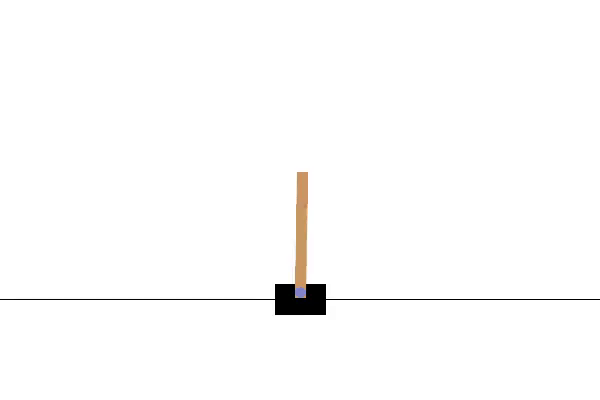

In [ ]:
best_model_path = f"{CHECKPOINTS_DIR}/a2c_seed_42/model_best.pth"
agent_model = ActorCritic(STATE_DIM, ACTION_DIM)
agent_model.load_state_dict(torch.load(best_model_path))
agent_model.eval()  # IMPORTANT: Set the model to evaluation mode
gym_simulation(ENV_NAME, agent_model)

---


### Part 4: Debugging and Troubleshooting in RL

Debugging RL algorithms is notoriously difficult because the agent's behavior, the environment, and
the learning algorithm are all tightly coupled. A bug might not cause a crash; instead, it might
just lead to the agent not learning. Here are some common problems and techniques to debug them.

#### Problem 1: The agent is not learning (flat reward curve).

- **Check Your Environment**: Is the observation space correct? Is the `done` signal being triggered
  appropriately?
- **Learning Rate is Too High/Low**: A very high learning rate can cause the policy to become
  chaotic, while a very low one can lead to painfully slow learning. This is where hyperparameter
  tuning (Part 7) becomes essential.
- **Bug in Reward Calculation**: Double-check your reward logic. In our A2C implementation, this is
  the calculation of `returns` and `advantages`. An off-by-one error or a mistake in the `gamma`
  application can kill learning.
- **Check Action Distribution**: Your policy should not collapse to a single action too quickly. Log
  the entropy of your policy distribution. If entropy drops to zero, the agent has stopped exploring
  and may be stuck in a suboptimal policy.

```python
  # Inside the training loop, after creating the distribution:
  entropy = dist.entropy().item()
  writer.add_scalar('Policy/entropy', entropy, episode)
```

#### Problem 2: Training is very unstable (reward goes up and down wildly).

- **High Learning Rate**: This is a classic symptom. The policy updates are too large, causing the
  agent to overshoot good policies.
- **Small Batch Size / High Variance**: In policy gradient methods, updates can have high variance.
  In our simple A2C, each episode is one "batch". If episodes are very short, the gradient estimates
  can be noisy. You can mitigate this by accumulating gradients over several episodes before
  performing an optimizer step.
- **Gradient Clipping**: Unstable training can lead to exploding gradients. We already added
  `torch.nn.utils.clip_grad_norm_`, which is a standard technique to prevent this by capping the
  magnitude of the gradients.
- **Value Function is not learning**: If the critic (`value` network) provides poor estimates of the
  state value, the `advantages` will be noisy, leading to unstable policy updates. Check the
  `critic_loss` in Tensorboard. If it's not decreasing, there might be an issue with your critic's
  architecture or learning rate.

#### General Debugging Tips:

- **Start Simple**: Always start with the simplest possible environment (like `CartPole`) and a
  known, stable algorithm before moving to more complex problems.
- **Sanity Check Model Outputs**: Before training, pass a dummy state through your model and check
  the shapes and value ranges of the output policy and value. The policy should be a valid
  probability distribution.
- **Read the Paper**: If you are implementing an algorithm from a paper, read it carefully. Small
  implementation details can make a huge difference.


---


### Part 5: The Importance of Multiple Seeds

RL algorithms can be very sensitive to the random seed, which affects weight initialization and
environment randomness. A great result on a single seed might just be luck. To get a reliable
estimate of an agent's performance, you **must** run experiments with multiple seeds and analyze the
aggregated results (mean and standard deviation).


Finished training for seed 42.
Finished training for seed 123.
Finished training for seed 789.


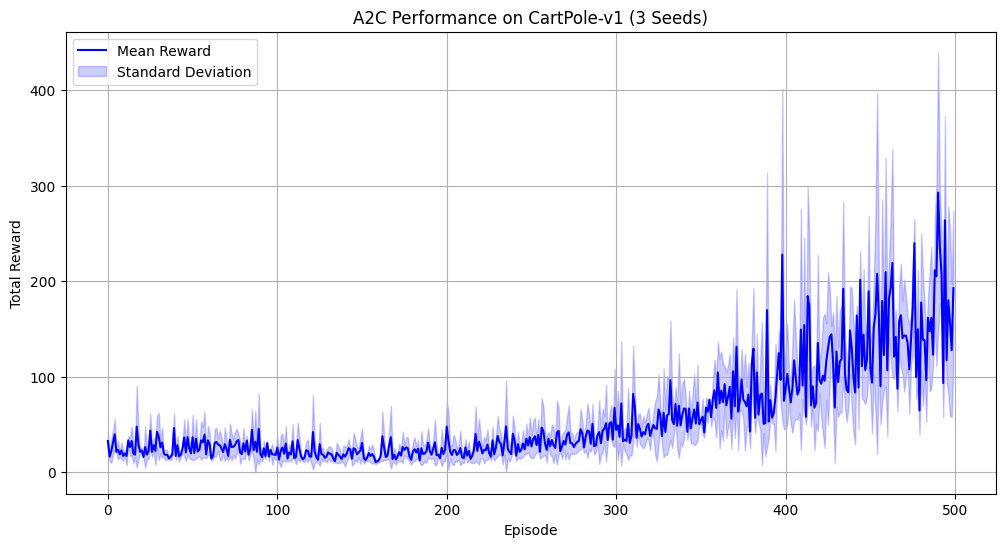

In [ ]:
def plot_rewards(rewards_list):
    """Plots the mean and standard deviation of rewards from multiple seeds."""
    plt.figure(figsize=(12, 6))

    rewards_array = np.array(rewards_list)
    mean_rewards = np.mean(rewards_array, axis=0)
    std_rewards = np.std(rewards_array, axis=0)

    plt.plot(mean_rewards, label="Mean Reward", color="blue")
    plt.fill_between(
        range(len(mean_rewards)),
        mean_rewards - std_rewards,
        mean_rewards + std_rewards,
        color="blue",
        alpha=0.2,
        label="Standard Deviation",
    )

    plt.title("A2C Performance on CartPole-v1 (3 Seeds)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()


seeds = [42, 123, 789]
all_rewards = []
for seed in seeds:
    rewards = train_with_monitoring(seed=seed, n_episodes=500)
    all_rewards.append(rewards)

plot_rewards(all_rewards)

---


### Part 6: Scaling with Parallelization (Ray)

#### How does Ray work?

**Ray** is a framework for distributed computing that makes it simple to scale Python applications
across multiple cores or machines. Its core philosophy is to turn regular Python functions and
classes into distributable, asynchronous tasks.

We will use two fundamental primitives from Ray Core:

1.  `@ray.remote`: A decorator that turns a Python class or function into a remote object or task
    that can be executed on a separate worker process.
2.  `ray.put()` and `ray.get()`: These functions are used to efficiently transfer objects (like our
    model's weights) to Ray's distributed object store and retrieve results from our remote workers.

Our strategy will be to create several remote **`RolloutWorker`** actors. The main training loop
will send the latest model weights to these workers, who will then independently collect experience
(run episodes) in parallel. The main loop then gathers this experience to perform a single, larger
update to the model.


In [ ]:
@ray.remote
class RolloutWorker:
    def __init__(self, env_name, seed):
        self.env = gym.make(env_name)
        self.seed = seed

    def run_episode(self, model_weights):
        state_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.n
        model = ActorCritic(state_dim, action_dim)
        model.load_state_dict(model_weights)

        states, actions, rewards = [], [], []
        state, _ = self.env.reset(seed=self.seed)
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                policy, _ = model(state_tensor)

            dist = Categorical(policy)
            action = dist.sample()

            next_state, reward, done, _, _ = self.env.step(action.item())

            states.append(state)
            actions.append(action.item())
            rewards.append(reward)

            state = next_state

        return states, actions, rewards

    def close(self):
        self.env.close()


def train_a2c_with_ray(n_batches=250, n_workers=4, lr=0.001, gamma=0.99):
    trainer = A2C_Trainer(STATE_DIM, ACTION_DIM, lr=lr, gamma=gamma)
    writer = SummaryWriter(f"{RUNS_DIR}/a2c_ray")

    workers = [RolloutWorker.remote(ENV_NAME, seed=i) for i in range(n_workers)]

    for batch_idx in range(n_batches):
        model_weights_id = ray.put(trainer.model.state_dict())
        futures = [w.run_episode.remote(model_weights_id) for w in workers]
        results = ray.get(futures)

        batch_reward = 0

        trainer.optimizer.zero_grad()

        for states, actions, rewards in results:
            batch_reward += sum(rewards)

            states_tensor = torch.FloatTensor(np.array(states))
            actions_tensor = torch.tensor(actions, dtype=torch.int64)

            policies, values = trainer.model(states_tensor)
            values = values.squeeze()

            dist = Categorical(policies)
            log_probs = dist.log_prob(actions_tensor)

            R = 0
            returns = [R := r + trainer.gamma * R for r in reversed(rewards)]
            returns.reverse()
            returns = torch.tensor(returns, dtype=torch.float32)

            advantages = returns - values.detach()
            actor_loss = -(log_probs * advantages).mean()
            critic_loss = nn.functional.mse_loss(returns, values)

            loss = (actor_loss + 0.5 * critic_loss) / n_workers

            loss.backward()

        trainer.optimizer.step()

        avg_reward = batch_reward / n_workers
        writer.add_scalar("Reward/avg_episode_reward", avg_reward, batch_idx * n_workers)
        if (batch_idx + 1) % 25 == 0:
            print(f"Batch {batch_idx+1}/{n_batches}, Avg Reward: {avg_reward:.2f}")

    writer.close()
    print("Closing remote worker environments...")
    ray.get([w.close.remote() for w in workers])
    print("Ray training finished.")


if ray.is_initialized():
    ray.shutdown()
ray.init(ignore_reinit_error=True)

train_a2c_with_ray()

ray.shutdown()

2025-07-20 20:36:56,690	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Batch 25/250, Avg Reward: 25.25
Batch 50/250, Avg Reward: 21.00
Batch 75/250, Avg Reward: 35.25
Batch 100/250, Avg Reward: 32.50
Batch 125/250, Avg Reward: 65.50
Batch 150/250, Avg Reward: 63.25
Batch 175/250, Avg Reward: 157.75
Batch 200/250, Avg Reward: 167.50
Batch 225/250, Avg Reward: 233.50
Batch 250/250, Avg Reward: 249.75
Closing remote worker environments...
Ray training finished.


---


### Part 7: Automated Hyperparameter Tuning (Optuna)

#### How does Optuna work?

**Optuna** is a hyperparameter optimization framework that automates the search for the best model
settings. It uses a "define-by-run" API that makes it highly flexible and Pythonic.

The core concepts we will use are:

1.  **Study**: A `study` object manages an entire optimization task. We define the goal (e.g.,
    `direction='maximize'`).
2.  **Trial**: A `trial` represents a single execution of our training process with a specific set
    of hyperparameters. Inside our objective function, we ask the `trial` object to `suggest` values
    for each hyperparameter (e.g., `trial.suggest_float('lr', ...)`).
3.  **Objective Function**: This is a function that Optuna will call repeatedly. It takes a `trial`
    object as input, runs our training, and returns a performance score (e.g., the average reward),
    which Optuna then tries to maximize or minimize.

Optuna uses intelligent sampling algorithms (like TPE) to choose which hyperparameter combinations
to try next, making it much more efficient than a simple grid search.


In [ ]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.9, 0.999, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    env = gym.make(ENV_NAME)
    trainer = A2C_Trainer(STATE_DIM, ACTION_DIM, lr, gamma, hidden_dim)

    episode_rewards = []
    for episode in range(150):
        log_probs, values, rewards, total_reward = trainer.run_episode(env)
        trainer.train_step(log_probs, values, rewards)
        episode_rewards.append(total_reward)

        trial.report(np.mean(episode_rewards[-50:]), step=episode)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    env.close()
    return np.mean(episode_rewards[-50:])


study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10, timeout=120)

print(f"Best trial value: {study.best_trial.value}")
print(f"Best params: {study.best_params}")

if optuna.visualization.is_available():
    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.show()
    fig2 = optuna.visualization.plot_param_importances(study)
    fig2.show()

[I 2025-07-20 20:37:04,863] A new study created in memory with name: no-name-bec3029a-bc98-4117-a23f-4e6d2fd510e0
[I 2025-07-20 20:37:05,781] Trial 0 finished with value: 17.2 and parameters: {'lr': 0.00132639226890059, 'gamma': 0.9470751298090344, 'hidden_dim': 64}. Best is trial 0 with value: 17.2.
[I 2025-07-20 20:37:06,584] Trial 1 finished with value: 21.66 and parameters: {'lr': 0.0001165014965617262, 'gamma': 0.9390279019424101, 'hidden_dim': 128}. Best is trial 1 with value: 21.66.
[I 2025-07-20 20:37:07,571] Trial 2 finished with value: 26.32 and parameters: {'lr': 0.00033955181031325335, 'gamma': 0.992043375526443, 'hidden_dim': 128}. Best is trial 2 with value: 26.32.
[I 2025-07-20 20:37:09,171] Trial 3 finished with value: 93.46 and parameters: {'lr': 0.0075712673724734145, 'gamma': 0.9234568302569608, 'hidden_dim': 64}. Best is trial 3 with value: 93.46.
[I 2025-07-20 20:37:09,908] Trial 4 finished with value: 12.92 and parameters: {'lr': 0.0005705093690413448, 'gamma': 0.

Best trial value: 412.56
Best params: {'lr': 0.00688133591828719, 'gamma': 0.9239450830807983, 'hidden_dim': 128}


---


### Part 8: Other Production Techniques

While we've covered the core hands-on tools, building a true production RL system involves a broader
set of MLOps (Machine Learning Operations) practices:

- **Configuration Management**: For larger projects, hard-coding hyperparameters is not scalable.
  Using configuration files (e.g., YAML or JSON) allows you to manage settings for different
  experiments cleanly.

- **Model Versioning and Deployment**: In a production environment, you need a system for versioning
  your models, tracking their performance, and deploying them to serve actions. Tools like
  **MLflow** are excellent for experiment tracking and model management, while **Kubeflow** can
  orchestrate entire ML pipelines on Kubernetes.

- **Continuous Integration/Continuous Deployment (CI/CD)**: A CI/CD pipeline automates the process
  of testing code, training models, and deploying them. For RL, this might mean a pipeline that
  automatically runs a suite of tests, triggers a new training run with multiple seeds, evaluates
  the resulting model against a baseline, and, if it's better, promotes it to production.

- **Safe Exploration**: In real-world applications like robotics or autonomous driving, a wrong
  action during exploration can be costly or dangerous. **Safe RL** is an entire subfield dedicated
  to this problem. Techniques include using a safety layer that overrides unsafe actions, or
  employing constrained optimization to ensure the agent's policy does not violate certain safety
  criteria during updates.


---


### Conclusion & Next Steps

In this notebook, we've elevated our RL code from a simple script to a more robust,
production-oriented setup. We've seen how to:

- **Structure** code for reuse.
- **Monitor** training to gain critical insights.
- **Checkpoint** models for safety and deployment.
- **Debug** common and frustrating RL issues.
- **Validate** results by running multiple seeds.
- **Scale** data collection with parallelization.
- **Automate** the search for optimal hyperparameters.

These techniques are the building blocks for applying Reinforcement Learning to solve real-world
problems. Happy training! 🚀
